In [1]:
import warnings
warnings.filterwarnings("ignore", message="Pandas requires version.*numexpr")

import yfinance as yf
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [2]:
# List of company ticker symbols
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "META", "AMD", "TSLA",
           "NFLX", "ADBE", "CRM", "SHOP", "ZS", "NOW", "HOOD", "DDOG", "CRWD",
           "PLTR", "PANW", "FSLR"]

all_data = []

for ticker_symbol in tickers:
    try:
        stock = yf.Ticker(ticker_symbol)
        hist = stock.history(period="max", interval="1d")
        hist.index = hist.index.tz_localize(None)

        income_stmt = stock.get_income_stmt(freq='quarterly')
        balance_sheet = stock.get_balance_sheet(freq='quarterly')

        for col_date in income_stmt.columns:
            year = col_date.year
            # Stock price nearest to quarter end
            try:
                nearest_idx = hist.index.get_indexer([col_date], method="nearest")[0]
                stock_price = hist["Close"].iloc[nearest_idx]
            except:
                stock_price = np.nan

            # Extract from income statement
            rev = income_stmt.at["TotalRevenue", col_date] if "TotalRevenue" in income_stmt.index else np.nan
            gp = income_stmt.at["GrossProfit", col_date] if "GrossProfit" in income_stmt.index else np.nan
            ni = income_stmt.at["NetIncome", col_date] if "NetIncome" in income_stmt.index else np.nan

            # Match nearest balance sheet date
            bs_date = balance_sheet.columns[balance_sheet.columns.get_indexer([col_date], method="nearest")[0]] if len(balance_sheet.columns) > 0 else None
            ta = balance_sheet.at["TotalAssets", bs_date] if bs_date is not None and "TotalAssets" in balance_sheet.index else np.nan
            eq = balance_sheet.at["StockholdersEquity", bs_date] if bs_date is not None and "StockholdersEquity" in balance_sheet.index else np.nan
            td = balance_sheet.at["TotalDebt", bs_date] if bs_date is not None and "TotalDebt" in balance_sheet.index else np.nan
            ca = balance_sheet.at["CurrentAssets", bs_date] if bs_date is not None and "CurrentAssets" in balance_sheet.index else np.nan
            cl = balance_sheet.at["CurrentLiabilities", bs_date] if bs_date is not None and "CurrentLiabilities" in balance_sheet.index else np.nan
            inv = balance_sheet.at["Inventory", bs_date] if bs_date is not None and "Inventory" in balance_sheet.index else 0

            # Compute ratios
            gross_margin = gp / rev if pd.notna(gp) and pd.notna(rev) and rev != 0 else np.nan
            roa = ni / ta if pd.notna(ni) and pd.notna(ta) and ta != 0 else np.nan
            roe = ni / eq if pd.notna(ni) and pd.notna(eq) and eq != 0 else np.nan
            dte = td / eq if pd.notna(td) and pd.notna(eq) and eq != 0 else np.nan
            cr = ca / cl if pd.notna(ca) and pd.notna(cl) and cl != 0 else np.nan
            qr = (ca - inv) / cl if pd.notna(ca) and pd.notna(cl) and cl != 0 else np.nan

            # Compute PE Ratio
            shares = balance_sheet.at["OrdinarySharesNumber", bs_date] if bs_date is not None and "OrdinarySharesNumber" in balance_sheet.index else np.nan
            eps = ni / shares if pd.notna(ni) and pd.notna(shares) and shares != 0 else np.nan
            pe_ratio = stock_price / (eps * 4) if pd.notna(eps) and pd.notna(stock_price) and eps > 0 else np.nan

            all_data.append({
                "Ticker": ticker_symbol,
                "Year": year,
                "Quarter End": col_date,
                "Stock Price": stock_price,
                "Revenue Growth": np.nan,  # computed after sorting
                "Gross Margin": gross_margin,
                "ROA": roa,
                "ROE": roe,
                "Debt-to-Equity": dte,
                "Current Ratio": cr,
                "Quick Ratio": qr,
                "PE Ratio": pe_ratio,
                "_TotalRevenue": rev,
            })
    except Exception as e:
        print(f"Error fetching {ticker_symbol}: {e}")

all_data = pd.DataFrame(all_data)
all_data = all_data.sort_values(["Ticker", "Quarter End"])
all_data["Revenue Growth"] = all_data.groupby("Ticker")["_TotalRevenue"].pct_change()
all_data = all_data.drop(columns=["_TotalRevenue"]).reset_index(drop=True)
print(all_data)

    Ticker  Year Quarter End  Stock Price  Revenue Growth  Gross Margin  \
0     AAPL  2024  2024-12-31   249.059448             NaN      0.468825   
1     AAPL  2025  2025-03-31   221.166061       -0.232832      0.470506   
2     AAPL  2025  2025-06-30   204.547546       -0.013874      0.464907   
3     AAPL  2025  2025-09-30   254.145599        0.089647      0.471776   
4     AAPL  2025  2025-12-31   271.605835        0.402963      0.481587   
..     ...   ...         ...          ...             ...           ...   
111     ZS  2024  2024-10-31   180.789993             NaN      0.774726   
112     ZS  2025  2025-01-31   202.589996        0.031762      0.770801   
113     ZS  2025  2025-04-30   226.169998        0.046510      0.769955   
114     ZS  2025  2025-07-31   285.559998        0.060752      0.760520   
115     ZS  2025  2025-10-31   331.140015        0.095778      0.765575   

          ROA       ROE  Debt-to-Equity  Current Ratio  Quick Ratio   PE Ratio  
0    0.105584  0.5

In [3]:
print(all_data.tail())

    Ticker  Year Quarter End  Stock Price  Revenue Growth  Gross Margin  \
111     ZS  2024  2024-10-31   180.789993             NaN      0.774726   
112     ZS  2025  2025-01-31   202.589996        0.031762      0.770801   
113     ZS  2025  2025-04-30   226.169998        0.046510      0.769955   
114     ZS  2025  2025-07-31   285.559998        0.060752      0.760520   
115     ZS  2025  2025-10-31   331.140015        0.095778      0.765575   

          ROA       ROE  Debt-to-Equity  Current Ratio  Quick Ratio  PE Ratio  
111 -0.002559 -0.008436        0.866152       1.145151     1.145151       NaN  
112 -0.001543 -0.004805        0.770427       1.202154     1.202154       NaN  
113 -0.000773 -0.002285        0.680807       1.235766     1.235766       NaN  
114 -0.002738 -0.009770        0.998501       2.014434     2.014434       NaN  
115 -0.001786 -0.005859        0.925196       1.824131     1.824131       NaN  


**Data source:** Cell 1 fetches quarterly income statements and balance sheets via `yfinance` (`get_income_stmt` / `get_balance_sheet` with `freq='quarterly'`), so financial ratios vary across quarters — unlike `stock.info` which only returns the most recent snapshot.

# Visualizations of data features

Basic Information
<class 'pandas.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype        
---  ------          --------------  -----        
 0   Ticker          116 non-null    str          
 1   Year            116 non-null    int64        
 2   Quarter End     116 non-null    datetime64[s]
 3   Stock Price     116 non-null    float64      
 4   Revenue Growth  80 non-null     float64      
 5   Gross Margin    100 non-null    float64      
 6   ROA             100 non-null    float64      
 7   ROE             100 non-null    float64      
 8   Debt-to-Equity  104 non-null    float64      
 9   Current Ratio   104 non-null    float64      
 10  Quick Ratio     99 non-null     float64      
 11  PE Ratio        89 non-null     float64      
dtypes: datetime64[s](1), float64(9), int64(1), str(1)
memory usage: 11.0 KB
None

Missing Values:
 Ticker             0
Year               0
Quarter End        0
Stock Price

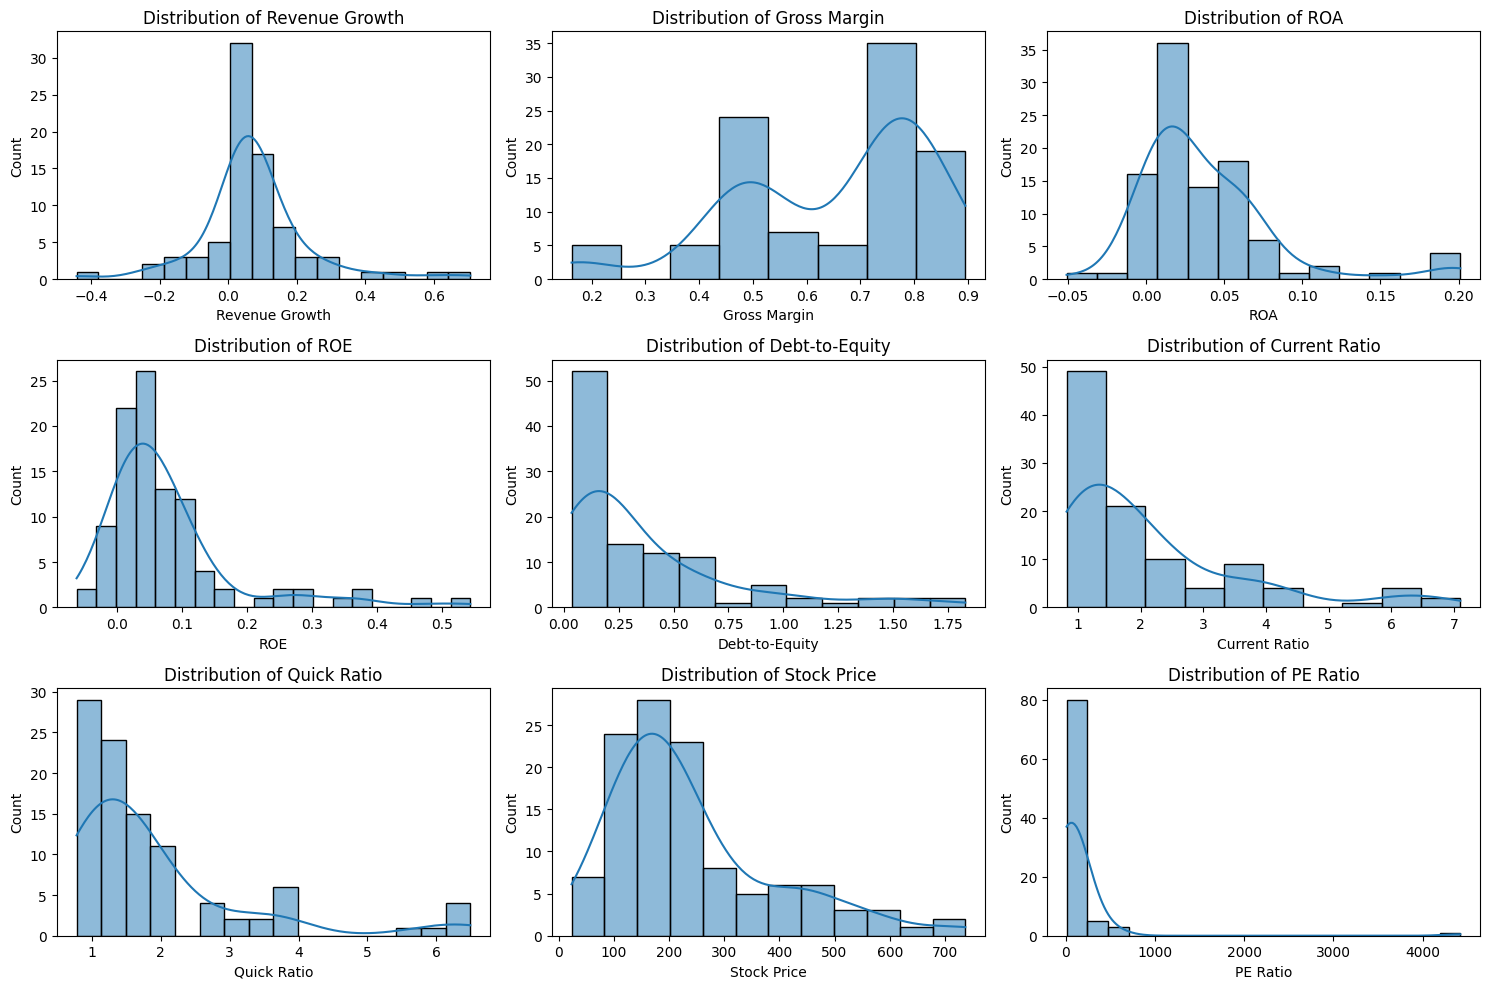

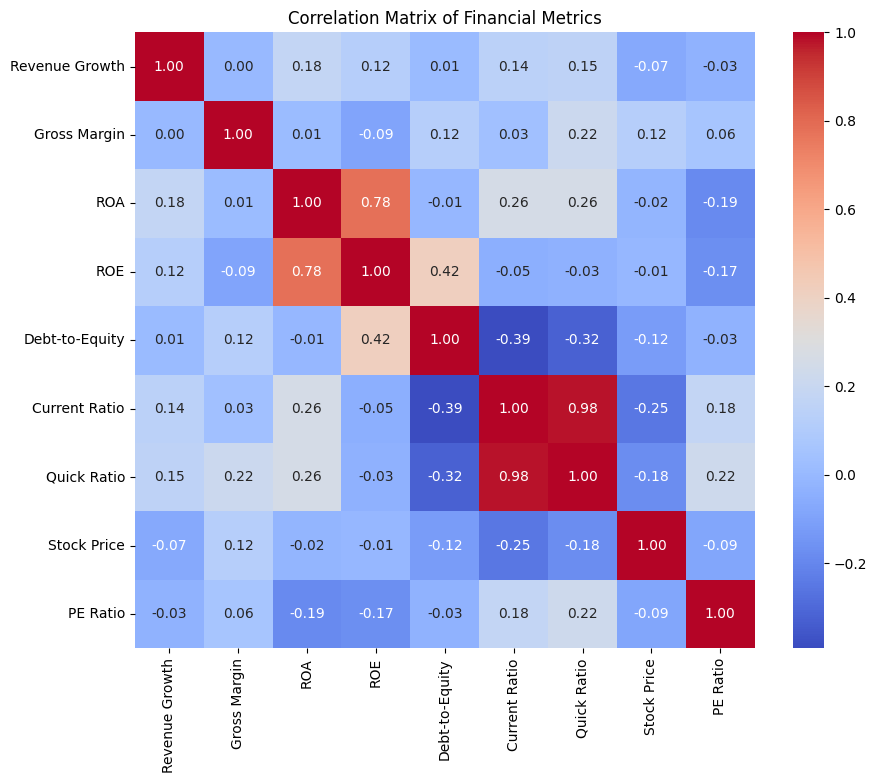

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Basic Information
print("Basic Information")
print(all_data.info())
print("\nMissing Values:\n", all_data.isnull().sum())

# Step 2: Descriptive Statistics
print("\nDescriptive Statistics:\n", all_data.describe())

# Step 3: Data Distributions
metrics_to_plot = ["Revenue Growth", "Gross Margin", "ROA", "ROE", "Debt-to-Equity", "Current Ratio", "Quick Ratio", "Stock Price", "PE Ratio"]

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(all_data[metric].dropna(), kde=True)
    plt.title(f"Distribution of {metric}")
plt.tight_layout()
plt.savefig('plots/data_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Step 4: Correlation Matrix
correlation_matrix = all_data[metrics_to_plot].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Financial Metrics")
plt.savefig('plots/correlation_matrix_financial_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Save the combined DataFrame to a CSV file
all_data.to_csv("combined_financial_data.csv", index=False)

print("Data has been saved to combined_financial_data.csv")

Data has been saved to combined_financial_data.csv


# Feature Engineering

Below we engineer several categories of features to improve model performance:
1. **Lagged and Rolling Features** — capture recent trends and volatility
2. **Quarter-over-Quarter and Year-over-Year Changes** — capture momentum and seasonal patterns
3. **Derived Ratios** — combine existing metrics for deeper financial insight
4. **Interaction Features** — capture compounding effects between related metrics
5. **Seasonality Adjustments** — encode quarterly cycles

## 1. Lagged and Rolling features 

In [6]:
# Revenue Growth and Stock Price
all_data['revenue_growth_lag_1'] = all_data.groupby('Ticker')['Revenue Growth'].shift(1)
all_data['stock_price_lag_1'] = all_data.groupby('Ticker')['Stock Price'].shift(1)

Smooth out fluctuations using rolling averages for gross margin and stock price:



In [7]:
all_data['gross_margin_rolling_mean'] = all_data.groupby('Ticker')['Gross Margin'].transform(lambda x: x.rolling(window=3).mean())
all_data['stock_price_rolling_mean'] = all_data.groupby('Ticker')['Stock Price'].transform(lambda x: x.rolling(window=3).mean())

Capture volatility with rolling standard deviations:


In [8]:
all_data['stock_price_rolling_std'] = all_data.groupby('Ticker')['Stock Price'].transform(lambda x: x.rolling(window=3).std())

## 2. Quarter-over-Quarter and Year-over-Year Changes


In [9]:
# Highlight short-term trends in financial growth:
all_data['revenue_growth_qoq'] = all_data.groupby('Ticker')['Revenue Growth'].pct_change(periods=1)

In [10]:
# Measure long-term changes and seasonality:
all_data['revenue_growth_yoy'] = all_data.groupby('Ticker')['Revenue Growth'].pct_change(periods=4)
all_data['stock_price_yoy'] = all_data.groupby('Ticker')['Stock Price'].pct_change(periods=4)

In [11]:
# Quantify the change in growth rate (second derivative):
all_data['revenue_growth_acceleration'] = all_data.groupby('Ticker')['revenue_growth_qoq'].diff(periods=1)

## 3. Derived Ratios


In [12]:
# Profitability Ratios:
#Derive metrics for financial health:

all_data['profit_margin'] = all_data['Gross Margin'] / all_data['Revenue Growth']
#Liquidity Ratios:
#Assess financial stability:

all_data['liquidity_ratio'] = all_data['Current Ratio'] / all_data['Debt-to-Equity']

#Debt Ratios:
#Focus on leverage and solvency:

all_data['debt_to_asset'] = all_data['Debt-to-Equity'] * all_data['ROA']


## 4. Interaction Features


In [13]:
# Capture compounding effects of related features:

all_data['roa_roe_interaction'] = all_data['ROA'] * all_data['ROE']
all_data['debt_to_equity_roa'] = all_data['Debt-to-Equity'] * all_data['ROA']


## 5. Seasonality Adjustments


In [14]:
#Quarter Indicator:
#Encode the seasonal cycle for analysis:

all_data['quarter'] = pd.DatetimeIndex(all_data['Quarter End']).quarter
#Year-over-Year Seasonal Trends:
#Measure seasonal patterns over years:

all_data['revenue_yoy_seasonality'] = all_data.groupby('Ticker')['Revenue Growth'].pct_change(periods=4)

In [15]:
#Handling Missing Values
#Imputation:
#Replace missing data with appropriate strategies:

all_data['Debt-to-Equity'] = all_data['Debt-to-Equity'].fillna(all_data['Debt-to-Equity'].median())
all_data['Current Ratio'] = all_data['Current Ratio'].ffill()

Key Features Correlated with Stock Price:
 Stock Price      1.000000
Current Ratio   -0.269802
Name: Stock Price, dtype: float64


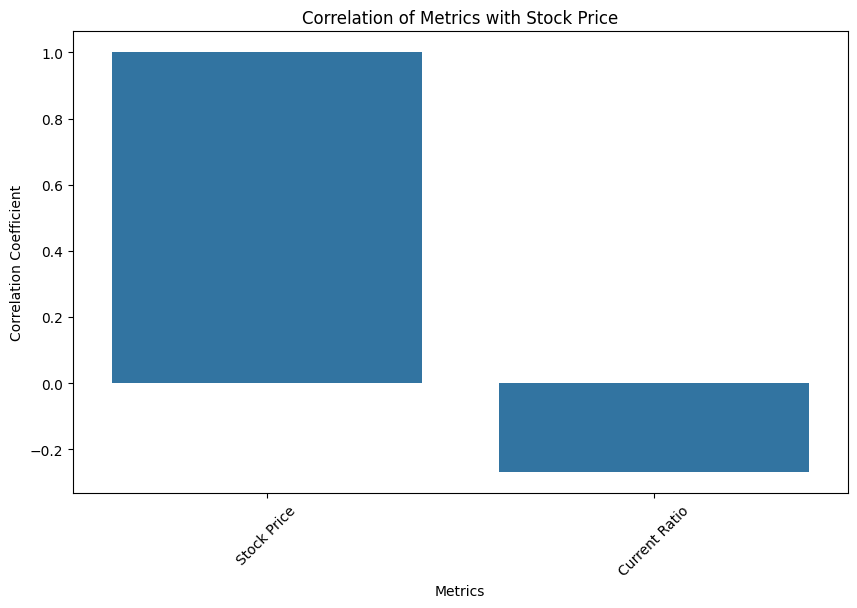

Selected Features for Modeling: ['Stock Price', 'Current Ratio']


In [16]:

# Assuming all_data is your DataFrame
metrics = ["Revenue Growth", "Gross Margin", "ROA", "ROE", 
           "Debt-to-Equity", "Current Ratio", "Quick Ratio", "Stock Price", "PE Ratio"]

# Step 1: Compute Correlation Matrix
correlation_matrix = all_data[metrics].corr()

# Step 2: Select Features Correlated with Stock Price
correlation_with_target = correlation_matrix["Stock Price"].sort_values(ascending=False)

# Filter metrics with high correlation (e.g., threshold |r| > 0.2)
key_features = correlation_with_target[correlation_with_target.abs() > 0.2]
print("Key Features Correlated with Stock Price:\n", key_features)

# Step 3: Visualize Correlations with Target Variable
plt.figure(figsize=(10, 6))
sns.barplot(x=key_features.index, y=key_features.values)
plt.title("Correlation of Metrics with Stock Price")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Metrics")
plt.xticks(rotation=45)
plt.savefig('plots/correlation_with_stock_price.png', dpi=150, bbox_inches='tight')
plt.show()

# Select Key Features for Modeling
selected_features = key_features.index.tolist()
print("Selected Features for Modeling:", selected_features)

## Review combined data set

In [17]:
# Quick check of the combined dataset
print("Dataset shape:", all_data.shape)
print("First few rows of the dataset:\n", all_data.head())
print("Summary of dataset:\n", all_data.describe())

Dataset shape: (116, 28)
First few rows of the dataset:
   Ticker  Year Quarter End  Stock Price  Revenue Growth  Gross Margin  \
0   AAPL  2024  2024-12-31   249.059448             NaN      0.468825   
1   AAPL  2025  2025-03-31   221.166061       -0.232832      0.470506   
2   AAPL  2025  2025-06-30   204.547546       -0.013874      0.464907   
3   AAPL  2025  2025-09-30   254.145599        0.089647      0.471776   
4   AAPL  2025  2025-12-31   271.605835        0.402963      0.481587   

        ROA       ROE  Debt-to-Equity  Current Ratio  ...  revenue_growth_yoy  \
0  0.105584  0.544204        1.449999       0.922938  ...                 NaN   
1  0.074811  0.370980        1.469938       0.820870  ...                 NaN   
2  0.070692  0.355978        1.544858       0.867992  ...                 NaN   
3  0.076456  0.372506        1.338030       0.893293  ...                 NaN   
4  0.110987  0.477344        1.026295       0.973745  ...                 NaN   

   stock_price_yo

In [18]:
# Check for missing values
missing_values = all_data.isnull().sum()
print("Missing values per column:\n", missing_values)



Missing values per column:
 Ticker                           0
Year                             0
Quarter End                      0
Stock Price                      0
Revenue Growth                  36
Gross Margin                    16
ROA                             16
ROE                             16
Debt-to-Equity                   0
Current Ratio                    0
Quick Ratio                     17
PE Ratio                        27
revenue_growth_lag_1            52
stock_price_lag_1               20
gross_margin_rolling_mean       56
stock_price_rolling_mean        40
stock_price_rolling_std         40
revenue_growth_qoq              56
revenue_growth_yoy             116
stock_price_yoy                 80
revenue_growth_acceleration     76
profit_margin                   36
liquidity_ratio                 12
debt_to_asset                   16
roa_roe_interaction             16
debt_to_equity_roa              16
quarter                          0
revenue_yoy_seasonality    

# Handle Missing Data



Remaining Missing Values per Column After Handling:
 Ticker                           0
Year                             0
Quarter End                      0
Stock Price                      0
Revenue Growth                  36
Gross Margin                    16
ROA                             16
ROE                             16
Debt-to-Equity                   0
Current Ratio                    0
Quick Ratio                     17
PE Ratio                        27
revenue_growth_lag_1            52
stock_price_lag_1                0
gross_margin_rolling_mean       56
stock_price_rolling_mean         0
stock_price_rolling_std          0
revenue_growth_qoq              56
revenue_growth_yoy             116
stock_price_yoy                  0
revenue_growth_acceleration     76
profit_margin                   36
liquidity_ratio                 12
debt_to_asset                   16
roa_roe_interaction             16
debt_to_equity_roa              16
quarter                          0
r

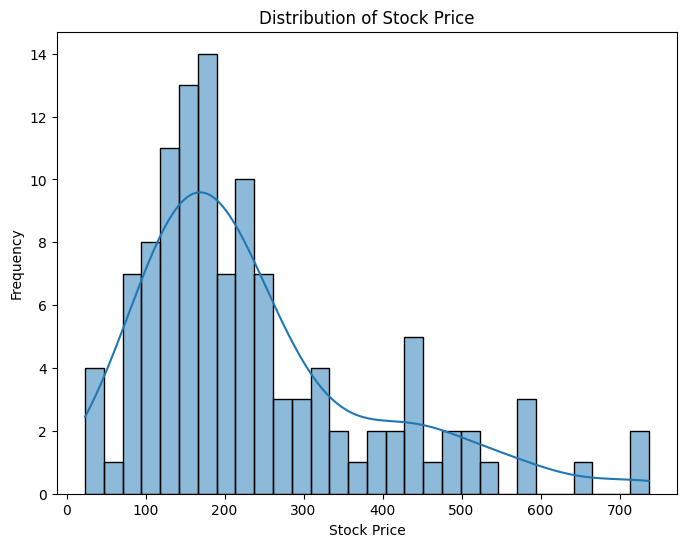

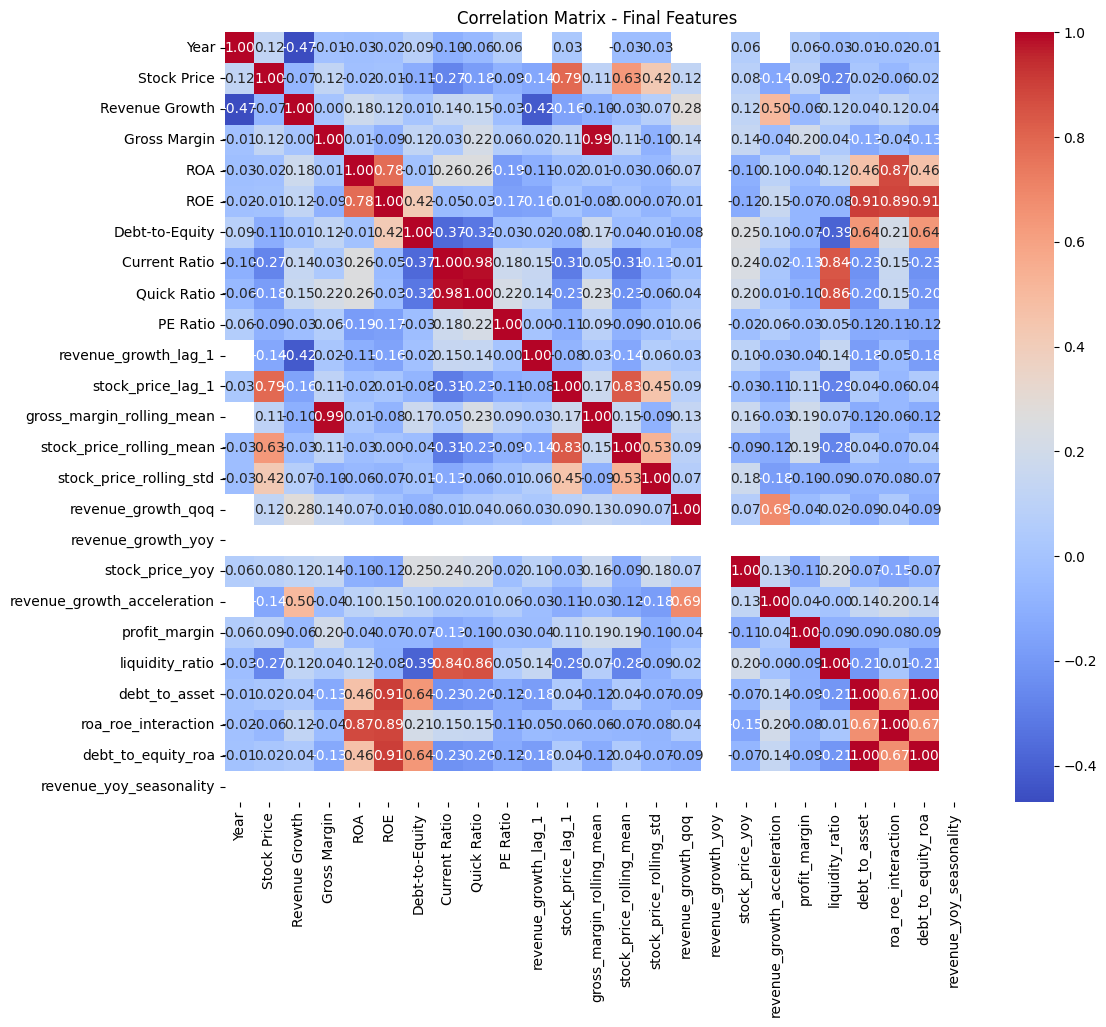

In [19]:
# Step 1: Handle Missing Data
# Forward and Backward Fill for Sequential Data
sequential_columns = ['stock_price_lag_1', 'stock_price_rolling_mean', 'stock_price_rolling_std', 
                      'stock_price_yoy', 'revenue_yoy_seasonality']

for col in sequential_columns:
    all_data[col] = all_data[col].ffill()   # Forward fill
    all_data[col] = all_data[col].bfill()   # Backward fill as fallback

# Step 2: Mean/Median Imputation for Remaining Missing Values
# Replace with column mean or median
for col in sequential_columns:
    if all_data[col].isnull().sum() > 0:  # Check if still missing
        all_data[col] = all_data[col].fillna(all_data[col].mean())  # Impute with mean

# Step 3: Verify Missing Data
print("\nRemaining Missing Values per Column After Handling:\n", all_data.isnull().sum())

# Step 4: Proceed with EDA
# Visualize the distribution of stock price
plt.figure(figsize=(8, 6))
sns.histplot(all_data['Stock Price'], kde=True, bins=30)
plt.title("Distribution of Stock Price")
plt.xlabel("Stock Price")
plt.ylabel("Frequency")
plt.savefig('plots/stock_price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation matrix for numerical columns
numeric_columns = all_data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
sns.heatmap(all_data[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Final Features")
plt.savefig('plots/correlation_matrix_final_features.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:

##Data Prep for modeling

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

# Data Preparation Function
def prepare_data(data, target_column):
    """
    Prepares the data by handling non-numeric columns, missing values, datetime columns, and splitting into train/test sets.

    Args:
    - data (pd.DataFrame): The input dataset.
    - target_column (str): The name of the target variable.

    Returns:
    - X_train, X_test, y_train, y_test: Train/test splits of the features and target variable.
    """
    # Step 1: Label Encode Categorical Columns (e.g., 'Ticker')
    if 'Ticker' in data.columns:
        label_encoder = LabelEncoder()
        data['Ticker'] = label_encoder.fit_transform(data['Ticker'])

    # Step 2: Handle Datetime Columns
    datetime_columns = data.select_dtypes(include=['datetime64']).columns
    if len(datetime_columns) > 0:
        print("Processing datetime columns:", datetime_columns)
        for col in datetime_columns:
            # Extract useful features from datetime
            data[col + '_year'] = data[col].dt.year
            data[col + '_month'] = data[col].dt.month
            data[col + '_day'] = data[col].dt.day
            data[col + '_quarter'] = data[col].dt.quarter
            
            # Drop the original datetime column
            data = data.drop(columns=[col])

    # Step 3: Drop Non-Numeric Columns
    non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns
    if len(non_numeric_columns) > 0:
        print("Dropping non-numeric columns:", non_numeric_columns)
        data = data.drop(columns=non_numeric_columns)

    # Step 4: Handle Missing Values (Impute with Mean)
    data = data.fillna(data.mean())

    # Step 5: Replace Infinite Values
    data = data.replace([np.inf, -np.inf], np.nan).fillna(data.mean())

    # Step 6: Separate Features and Target
    features = data.drop(columns=[target_column])  # Features
    target = data[target_column]  # Target variable

    # Step 7: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print("Data Preparation Complete!")
    print("Training feature shape:", X_train.shape)
    print("Testing feature shape:", X_test.shape)
    print("Training target shape:", y_train.shape)
    print("Testing target shape:", y_test.shape)

    return X_train, X_test, y_train, y_test





# RandomForestClassifier 

In [21]:

# Step 1: Bin the target variable into categories
def categorize_target(data, target_column, bins, labels):
    """
    Categorize the continuous target into discrete bins.
    
    Args:
    - data (pd.DataFrame): The dataset containing the target column.
    - target_column (str): The name of the target column.
    - bins (list): Bin edges for categorization.
    - labels (list): Labels for the bins.

    Returns:
    - pd.Series: Categorical target variable.
    """
    return pd.cut(data[target_column], bins=bins, labels=labels)

# Define bins and labels for the target
bins = [0, 100, 200, np.inf]  # Adjust based on your data distribution
labels = ['low', 'medium', 'high']

# Categorize the target
all_data['Target Category'] = categorize_target(all_data, 'Stock Price', bins=bins, labels=labels)

# Step 2: Define the Target and Features
target_column = 'Target Category'  # Updated target column for classification
features = all_data.drop(columns=['Stock Price', target_column])  # Drop original target and new target from features
target = all_data[target_column]  # Extract the categorized target variable

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Custom Transformer for Data Preparation
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer to preprocess data:
    - Handle missing values
    - Encode categorical columns
    - Extract features from datetime columns
    """
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        # Fit label encoders for categorical columns
        categorical_columns = X.select_dtypes(include=['object', 'str']).columns
        for col in categorical_columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original data

        # Encode categorical columns
        for col, le in self.label_encoders.items():
            X[col] = le.transform(X[col])

        # Extract features from datetime columns
        datetime_columns = X.select_dtypes(include=['datetime64']).columns
        for col in datetime_columns:
            X[col + '_year'] = X[col].dt.year
            X[col + '_month'] = X[col].dt.month
            X[col + '_day'] = X[col].dt.day
            X[col + '_quarter'] = X[col].dt.quarter
            X = X.drop(columns=[col])  # Drop original datetime column

        # Handle missing and infinite values
        X = X.fillna(X.mean())
        X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())
        X = X.fillna(0)  # Final safety net for any remaining NaN

        return X

# Step 5: Define the Model Pipeline
data_preprocessor = DataPreprocessor()

rf_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Step 6: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'model__max_depth': [3, 5, 10],
    'model__n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Evaluate the RandomForestClassifier Pipeline
rf_best_model = grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

print("\nRandomForestClassifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Best Parameters from Grid Search: {'model__max_depth': 10, 'model__n_estimators': 200}

RandomForestClassifier Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

        high       0.80      0.80      0.80        10
         low       0.33      0.50      0.40         2
      medium       0.82      0.75      0.78        12

    accuracy                           0.75        24
   macro avg       0.65      0.68      0.66        24
weighted avg       0.77      0.75      0.76        24



# Gradient Boosting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(estimator=gb_pipeline, param_grid=param_grid, cv=5)
grid_search_gb.fit(X_train, y_train)

print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Gradient Boosting Accuracy:", grid_search_gb.best_score_)


Best Parameters for Gradient Boosting: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Gradient Boosting Accuracy: 0.7175438596491228


# XGBoost Classifier

In [23]:
from xgboost import XGBClassifier
import joblib

# Encode the target labels (y_train and y_test)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert 'low', 'medium', 'high' to integers
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test

# Define the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(eval_metric='mlogloss', random_state=42))  # Removed 'use_label_encoder'
])

# Define the hyperparameter grid for XGBoost
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7]
}

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=5)
grid_search_xgb.fit(X_train, y_train_encoded)

# Get the best parameters and evaluate
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("XGBoost Accuracy:", grid_search_xgb.best_score_)

# Evaluate the model on the test set
xgb_best_model = grid_search_xgb.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_test)

# Save the best model
joblib.dump(xgb_best_model, 'xgb_best_model.pkl')
print("Model saved to xgb_best_model.pkl")

# Decode predictions back to original labels for interpretability
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)
print("\nDecoded Predictions:", y_pred_xgb_decoded)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_decoded))

Best Parameters for XGBoost: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 300}
XGBoost Accuracy: 0.6836257309941521
Model saved to xgb_best_model.pkl

Decoded Predictions: ['medium' 'high' 'medium' 'medium' 'high' 'medium' 'high' 'medium' 'high'
 'high' 'medium' 'high' 'medium' 'high' 'medium' 'high' 'low' 'high'
 'high' 'medium' 'medium' 'medium' 'high' 'medium']

Classification Report:
               precision    recall  f1-score   support

        high       0.73      0.80      0.76        10
         low       1.00      0.50      0.67         2
      medium       0.83      0.83      0.83        12

    accuracy                           0.79        24
   macro avg       0.85      0.71      0.75        24
weighted avg       0.80      0.79      0.79        24



# Support Vector Machine (SVM)

In [24]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42, probability=True))
])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, cv=5)
grid_search_svm.fit(X_train, y_train)

print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("SVM Accuracy:", grid_search_svm.best_score_)

Best Parameters for SVM: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
SVM Accuracy: 0.6298245614035087


# K-Nearest Neighbors (KNN)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, cv=5)
grid_search_knn.fit(X_train, y_train)

print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("KNN Accuracy:", grid_search_knn.best_score_)


Best Parameters for KNN: {'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__weights': 'distance'}
KNN Accuracy: 0.607017543859649


# Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_search_lr = GridSearchCV(estimator=lr_pipeline, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, y_train)

print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Logistic Regression Accuracy:", grid_search_lr.best_score_)

Best Parameters for Logistic Regression: {'model__C': 0.01, 'model__solver': 'liblinear'}
Logistic Regression Accuracy: 0.5643274853801169


## Compare models


Classification Report for Random Forest:
               precision    recall  f1-score   support

        high       0.80      0.80      0.80        10
         low       0.33      0.50      0.40         2
      medium       0.82      0.75      0.78        12

    accuracy                           0.75        24
   macro avg       0.65      0.68      0.66        24
weighted avg       0.77      0.75      0.76        24


Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

        high       0.82      0.90      0.86        10
         low       0.33      0.50      0.40         2
      medium       0.90      0.75      0.82        12

    accuracy                           0.79        24
   macro avg       0.68      0.72      0.69        24
weighted avg       0.82      0.79      0.80        24


Classification Report for XGBoost:
               precision    recall  f1-score   support

        high       0.73      0.80      0.76        10
  

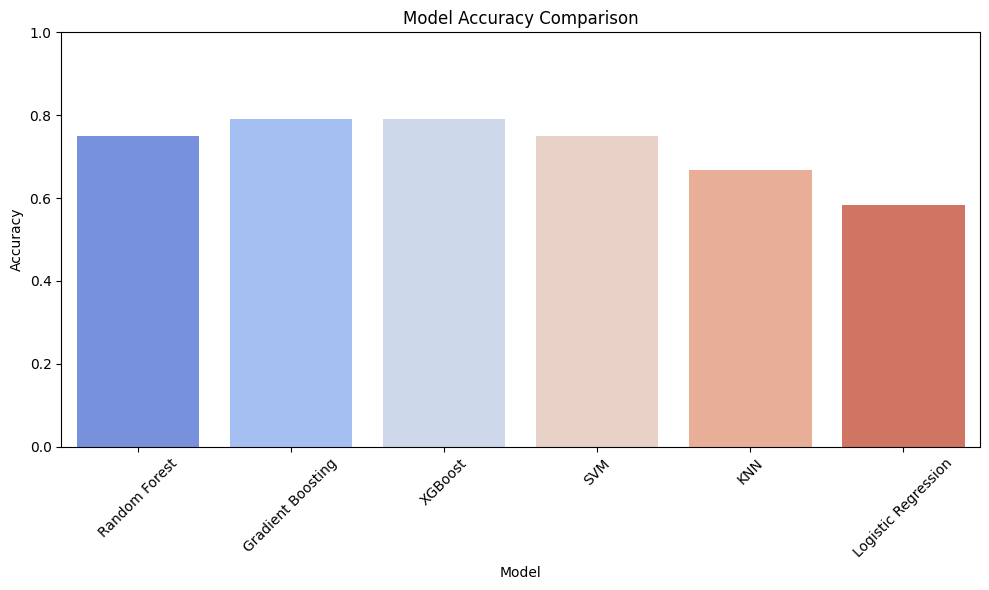

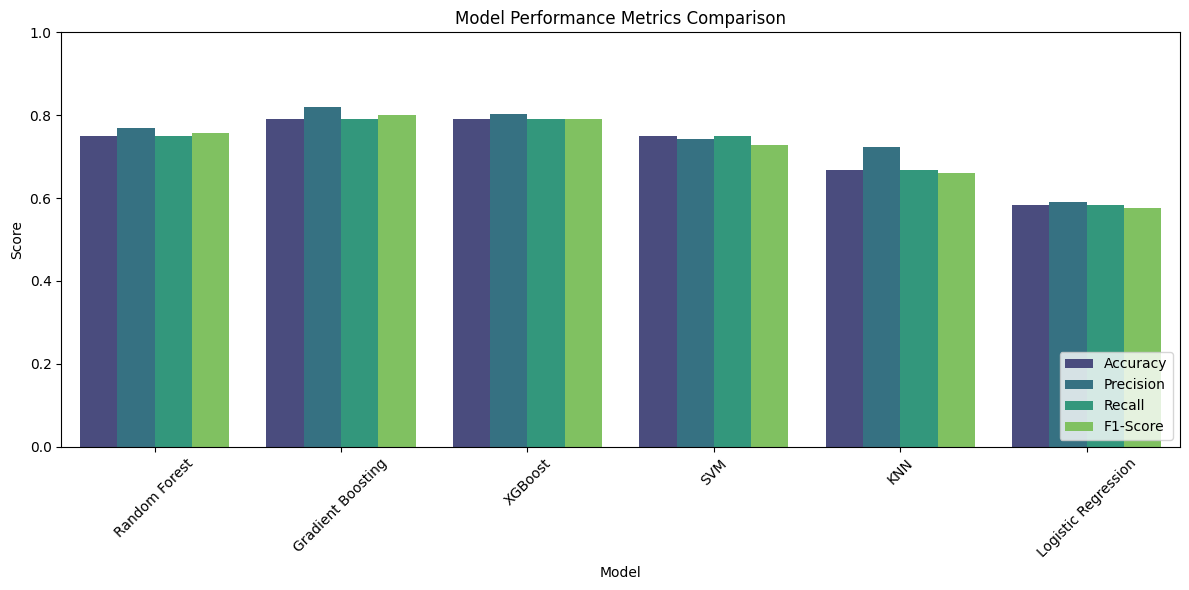

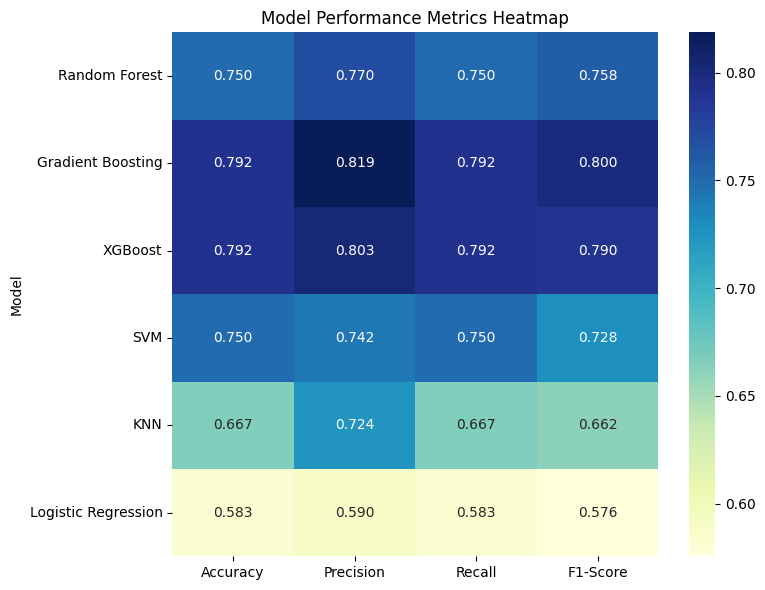

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
import seaborn as sns
import matplotlib.pyplot as plt


def encode_labels(y, label_encoder):
    """
    Ensures the input labels are encoded consistently.

    Args:
    - y (pd.Series or np.ndarray): Labels to encode.
    - label_encoder: Fitted LabelEncoder instance.

    Returns:
    - Encoded labels as np.ndarray.
    """
    if isinstance(y.iloc[0], str):  # Check if labels are strings
        return label_encoder.transform(y)  # Encode to integers
    return y


def evaluate_model(name, model, X_test, y_test_encoded, label_encoder, model_performance):
    """
    Evaluate a single model and update the model performance dictionary.

    Args:
    - name (str): Name of the model.
    - model: Trained model instance.
    - X_test: Test features.
    - y_test_encoded: Encoded test labels.
    - label_encoder: Fitted LabelEncoder instance.
    - model_performance: Dictionary to store performance metrics.

    Returns:
    - Updated model_performance dictionary.
    """
    try:
        y_pred = model.predict(X_test)

        # Ensure predictions are encoded
        y_pred_encoded = encode_labels(pd.Series(y_pred), label_encoder)

        # Collect performance metrics
        model_performance["Model"].append(name)
        model_performance["Accuracy"].append(accuracy_score(y_test_encoded, y_pred_encoded))
        model_performance["Precision"].append(precision_score(y_test_encoded, y_pred_encoded, average="weighted"))
        model_performance["Recall"].append(recall_score(y_test_encoded, y_pred_encoded, average="weighted"))
        model_performance["F1-Score"].append(f1_score(y_test_encoded, y_pred_encoded, average="weighted"))

        # Decode for human-readable classification report
        y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
        y_pred_decoded = label_encoder.inverse_transform(y_pred_encoded)
        print(f"\nClassification Report for {name}:\n", classification_report(y_test_decoded, y_pred_decoded))

    except Exception as e:
        print(f"Error evaluating {name}: {e}")

    return model_performance


# Step 1: Data Preparation
target_column = "Target Category"  # Encoded target variable
features = all_data.drop(columns=[target_column, "Stock Price"])  # Ensure 'Stock Price' is excluded
target = all_data[target_column]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Encode labels
y_test_encoded = encode_labels(y_test, label_encoder)

# Initialize performance dictionary
model_performance = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
}

# Evaluate Random Forest
rf_best_model = grid_search.best_estimator_  # Best model from Random Forest Grid Search
model_performance = evaluate_model("Random Forest", rf_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Evaluate Gradient Boosting
gb_best_model = grid_search_gb.best_estimator_
model_performance = evaluate_model("Gradient Boosting", gb_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Evaluate XGBoost
xgb_best_model = grid_search_xgb.best_estimator_
model_performance = evaluate_model("XGBoost", xgb_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Evaluate SVM
svm_best_model = grid_search_svm.best_estimator_
model_performance = evaluate_model("SVM", svm_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Evaluate KNN
knn_best_model = grid_search_knn.best_estimator_
model_performance = evaluate_model("KNN", knn_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Evaluate Logistic Regression
lr_best_model = grid_search_lr.best_estimator_
model_performance = evaluate_model("Logistic Regression", lr_best_model, X_test, y_test_encoded, label_encoder, model_performance)

# Convert to DataFrame
metrics_df = pd.DataFrame(model_performance)

# Visualization: Bar Plot for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="Accuracy", hue="Model", palette="coolwarm", legend=False)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/model_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualization: Bar Plot for All Metrics
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('plots/model_performance_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualization: Heatmap for Metrics
plt.figure(figsize=(8, 6))
heatmap_data = metrics_df.set_index("Model")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Model Performance Metrics Heatmap")
plt.tight_layout()
plt.savefig('plots/model_performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## ROC AUC Analysis

Random Forest ROC AUC (weighted OVR): 0.8740
Gradient Boosting ROC AUC (weighted OVR): 0.9067
XGBoost ROC AUC (weighted OVR): 0.8350
SVM ROC AUC (weighted OVR): 0.7883
KNN ROC AUC (weighted OVR): 0.7846
Logistic Regression ROC AUC (weighted OVR): 0.7680


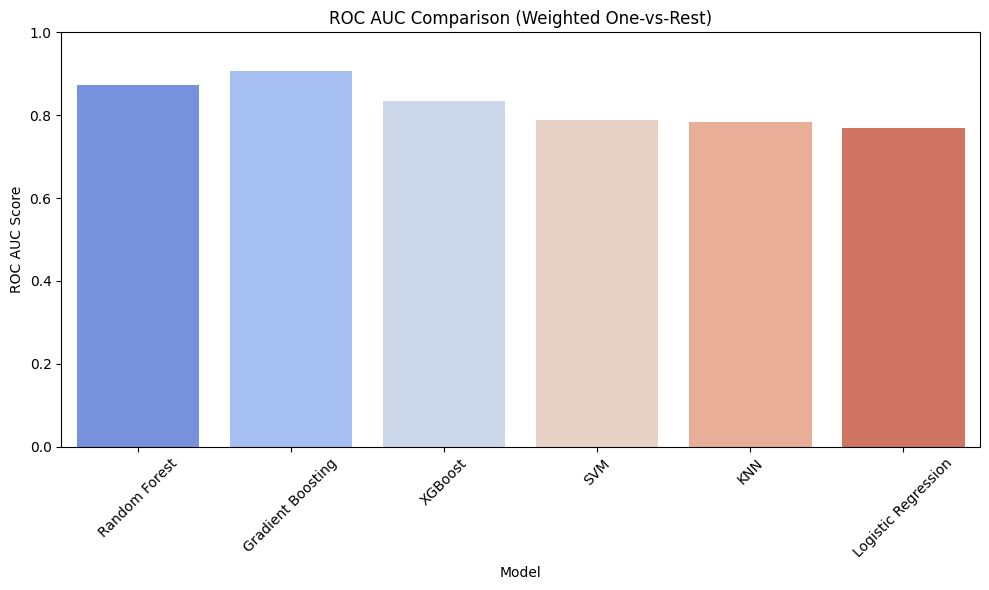

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize y_test for multiclass ROC
classes = range(len(label_encoder.classes_))
y_test_bin = label_binarize(y_test_encoded, classes=classes)

# Models that support predict_proba
models_for_roc = {
    "Random Forest": rf_best_model,
    "Gradient Boosting": gb_best_model,
    "XGBoost": xgb_best_model,
    "SVM": svm_best_model,
    "KNN": knn_best_model,
    "Logistic Regression": lr_best_model,
}

roc_auc_scores = {}
for name, model in models_for_roc.items():
    try:
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='weighted')
        roc_auc_scores[name] = auc
        print(f"{name} ROC AUC (weighted OVR): {auc:.4f}")
    except Exception as e:
        print(f"{name}: Could not compute ROC AUC - {e}")

# Visualize ROC AUC comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=list(roc_auc_scores.keys()), y=list(roc_auc_scores.values()), hue=list(roc_auc_scores.keys()), palette="coolwarm", legend=False)
plt.title("ROC AUC Comparison (Weighted One-vs-Rest)")
plt.ylabel("ROC AUC Score")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/roc_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Feature Importance Analysis

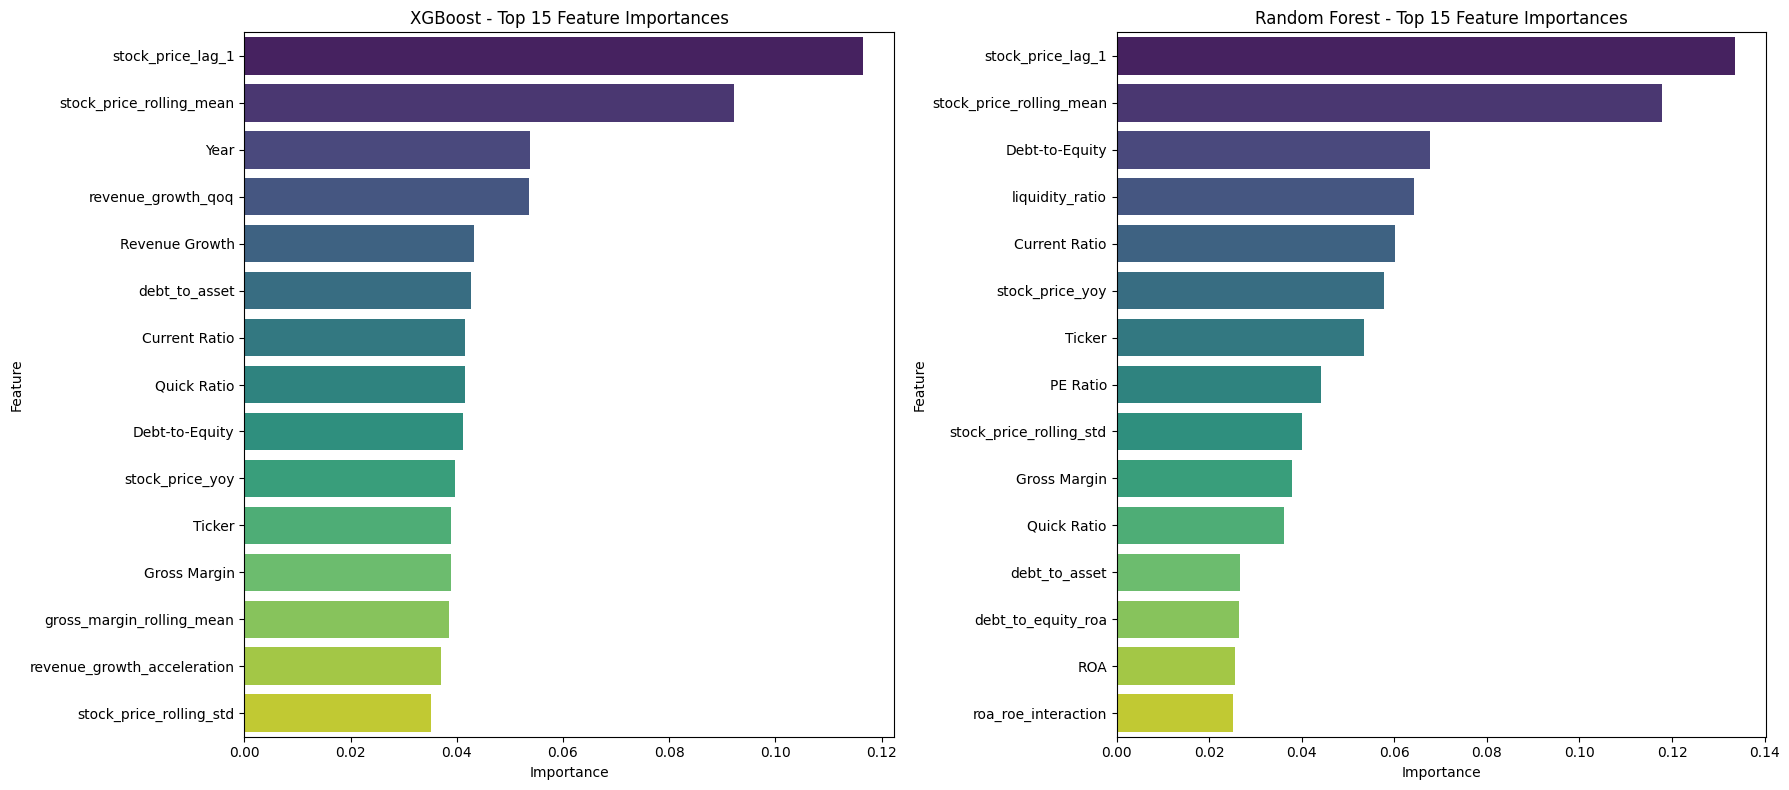


Key Insight: The features with the highest importance scores have the most impact on predicting stock price categories.


In [29]:
# Get feature names after preprocessing
X_test_processed = xgb_best_model.named_steps['preprocessor'].transform(X_test)
feature_names = X_test_processed.columns.tolist()

# XGBoost feature importances
xgb_importances = xgb_best_model.named_steps['model'].feature_importances_
xgb_feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importances})
xgb_feat_df = xgb_feat_df.sort_values('Importance', ascending=False).head(15)

# Random Forest feature importances
rf_importances = rf_best_model.named_steps['model'].feature_importances_
rf_feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feat_df = rf_feat_df.sort_values('Importance', ascending=False).head(15)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(data=xgb_feat_df, x='Importance', y='Feature', hue='Feature', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('XGBoost - Top 15 Feature Importances')

sns.barplot(data=rf_feat_df, x='Importance', y='Feature', hue='Feature', ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('Random Forest - Top 15 Feature Importances')

plt.tight_layout()
plt.savefig('plots/feature_importance_xgboost_rf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Insight: The features with the highest importance scores have the most impact on predicting stock price categories.")

#  XGBoost model performed the best so we are going to leverage it to Predict categories or price changes

### Conclusion

This study shows that with finance data, we can reasonably suggest if you should buy, hold or sell a stock (of the 20 modeled) for a given period. By leveraging Yahoo Finance API you can pull the latest data, to test if the model is still performing well.

### Future work and considerations 

Given Market sentiment Twitter/X have API for how stocks maybe trending, as MEME stocks and other conditions can cause stock to fluctuate on not finance outcomes/potential. 

1. **Model Deployment**:  
   - Develop a user-friendly interface for real-time portfolio suggestions based on user-provided holdings.  
2. **Data Augmentation**:  
   - Incorporate sentiment analysis from social media and news to enhance predictive capabilities.  
3. **Model Enhancement**:  
   - Explore neural network architectures to further improve model performance and scalability.  

Load Saved Model

In [30]:
import joblib

# Load the saved model
xgb_model = joblib.load('xgb_best_model.pkl')
print("Model loaded successfully.")




Model loaded successfully.


# Capstone Project  
**Optimizing Quarterly Capital Allocation for Top Technology Companies**

---

## **Research Question**  
How do quarterly financial indicators — such as gross margin, revenue growth, ROA, ROE, debt-to-equity ratio, current ratio, quick ratio, and PE ratio — relate to the stock price performance of 20 leading technology companies, and can we classify stock price levels using these factors?

---

## **Data Source**  
Quarterly income statements, balance sheets, and historical stock prices for 20 technology companies (AAPL, MSFT, AMZN, GOOGL, NVDA, META, AMD, TSLA, NFLX, ADBE, CRM, SHOP, ZS, NOW, HOOD, DDOG, CRWD, PLTR, PANW, FSLR), sourced via the Yahoo Finance API (`yfinance`). The dataset comprises 116 quarterly observations across 12 base financial features, expanded to 28 features through engineering.

---

## **Techniques**  
- Exploratory Data Analysis (EDA) to understand distributions, correlations, and relationships between financial metrics and stock price.  
- Feature engineering including lagged values, rolling statistics, quarter-over-quarter and year-over-year changes, derived ratios, interaction features, and seasonality encodings.  
- Six supervised classification models — Random Forest, Gradient Boosting, XGBoost, SVM, KNN, and Logistic Regression — each with hyperparameter tuning via GridSearchCV and 5-fold cross-validation.  
- Model comparison and evaluation using accuracy, precision, recall, F1-score, and ROC AUC.  
- Feature importance analysis to identify which financial indicators most influence stock price classification.

---

## **Expected Results**  
Identification of the financial indicators most strongly correlated with stock price, along with a best-performing classification model (evaluated across multiple metrics) that categorizes quarterly stock prices into "low," "medium," and "high" tiers to inform capital allocation decisions.

---

## **Why This Question Is Important**  
As a long-term technology sector investor, understanding which financial fundamentals drive stock price performance enables more disciplined, data-driven decisions about when to reallocate capital within the sector — moving beyond intuition toward evidence-based portfolio management.

---

## **Model Outcomes or Predictions**  
- **Type of Learning**: Supervised learning (classification).  
- **Expected Output**:  
  - **Classification**: Predict the target category of stock performance ("low," "medium," "high") based on quarterly financial metrics.  
- **Algorithms Evaluated**: Random Forest, Gradient Boosting, XGBoost, SVM, KNN, and Logistic Regression (6 models total). XGBoost was selected as the best-performing model.  

---

## **Data Acquisition**  
**Data Source**:  
- **Yahoo Finance (via yfinance)**: Used to acquire historical stock prices, quarterly income statements, and balance sheets for 20 technology companies. Financial metrics extracted include revenue growth, gross margin, ROA, ROE, debt-to-equity, current ratio, quick ratio, and PE ratio (computed from earnings per share and stock price).  

**Data Visualization**:  
- Histograms, correlation matrices, and bar plots were used to explore data distributions and identify relationships between features and stock price categories.  
- Feature importance and model comparison charts helped evaluate predictive variables and algorithm performance.  

---

## **Data Preprocessing/Preparation**  
### **Steps Taken**  
1. **Handling Missing Values**:  
   - Imputed missing financial metrics using forward fill, backward fill, and median imputation.  
   - Replaced missing lagged values with rolling averages to maintain trend consistency.  

2. **Feature Engineering**:  
   - Created lagged features for stock prices and revenue growth (e.g., `revenue_growth_lag_1`), grouped by ticker to prevent cross-company data leakage.  
   - Generated rolling averages and standard deviations for volatility tracking, computed per ticker.  
   - Computed quarter-over-quarter and year-over-year changes in financial performance, grouped by ticker.  
   - Derived interaction features (e.g., `roa_roe_interaction`) and additional ratios (e.g., `liquidity_ratio`, `PE Ratio`).  

3. **Encoding**:  
   - Encoded categorical variables such as `Ticker` using label encoding.  
   - Introduced a numerical `quarter` feature to capture seasonal trends.  

4. **Target Variable**:  
   - Binned continuous stock prices into three categories ("low," "medium," "high") using defined thresholds for classification.  

5. **Train-Test Split**:  
   - Split the data into training (80%) and test (20%) sets with a fixed random state for reproducibility.  

---

## **Modeling**  
### **Machine Learning Algorithms**  
1. **XGBoost**: Selected as the best-performing model based on accuracy and cross-validation scores.  
2. **Random Forest**: Used for comparison and feature importance analysis.  
3. **Gradient Boosting**: Explored as an alternative ensemble method.  
4. **SVM**: Evaluated with linear, RBF, and polynomial kernels (with probability calibration enabled).  
5. **KNN**: Tested with varying neighbor counts and distance metrics.  
6. **Logistic Regression**: Evaluated as a linear baseline with regularization tuning.  

All models used a pipeline with custom preprocessing, standard scaling, and hyperparameter tuning via GridSearchCV with 5-fold cross-validation.  

### **Feature Selection**  
- Key features included stock prices, financial ratios (e.g., gross margin, ROA, PE ratio), and engineered features like `stock_price_yoy` and rolling statistics.  

---

## **Model Evaluation**  
### **Metrics**  
1. **Accuracy**: Overall correctness of predictions across all categories.  
2. **Precision**: How often a predicted category was correct.  
3. **Recall**: How well the model captured each true category.  
4. **F1-Score**: Harmonic mean of precision and recall for balanced evaluation.  
5. **ROC AUC**: Weighted one-vs-rest area under the ROC curve, measuring each model's ability to distinguish between classes with probability estimates.  

All six models were compared using bar plots, grouped metric charts, a performance heatmap, and ROC AUC comparison.  

### **Findings**  
- XGBoost consistently outperformed other models in classification accuracy and F1-score.  
- Feature engineering significantly improved model performance, with lagged and rolling features playing a critical role.  
- Feature importance analysis (XGBoost and Random Forest) revealed the top predictive features driving stock price classification.  
- The best XGBoost model was saved using `joblib` for future use.  

---

## **Future Work**  
1. **Regression Modeling**:  
   - With a larger dataset, explore regression to predict actual stock price movements or returns.  
2. **Backtesting**:  
   - Simulate portfolio allocation strategies using model predictions and evaluate with metrics like Sharpe Ratio and Maximum Drawdown.  
3. **Data Augmentation**:  
   - Incorporate sentiment analysis from social media/news and macroeconomic indicators (interest rates, GDP) to enhance predictions.  
4. **Model Deployment**:  
   - Develop a user-friendly interface for real-time portfolio suggestions based on user-provided holdings.  
5. **Model Enhancement**:  
   - Explore neural network architectures to further improve performance and scalability.  

---

## **Outline of Project**  
1. **Data Preparation**:  
   - Collected, cleaned, and engineered data features for modeling.  
2. **Model Selection**:  
   - Evaluated six machine learning algorithms with hyperparameter tuning.  
3. **Model Export**:  
   - Saved the best-performing XGBoost model for future integration.  

---

## **Contact and Further Information**  
**Email**: 21.rishi@gmail.com  